In [1]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.time_data import TimeData
from dftpy.optimization import Optimization
from dftpy.mpi import sprint

from qepy.calculator import QEpyCalculator 
from qepy.io import QEInput
from qepy.driver import Driver

from ase.build import bulk
from ase.io import read
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

import pickle

/home/valeria/anaconda3/lib/python3.9/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


#### Porpose of this code
Evaluate the energy of the system using OFDFT with the  $\rho_{0}$'s found in the code named rho0_dT. In this code we will use the KS electron density, and we will include in the OF calculation the corrected Wang-Teter KEDF to obtain the equation of states graph.

In [2]:
path_pp='.../dftpy/examples/ofpp/EAC/upf/blps/'
file1='si.lda.upf'
PP_list = {'Si': path_pp+file1}

In [11]:
rho00 = np.load('.../Si-bcc/DATA2/rho0.npy')
KS_TE = []
for i in np.arange(0,30,1):
    with open('.../Si-bcc/DATA2/Si'+str(i)+'.out') as D:
        k = [match for match in D if "Total energy" in match]
    KS_te = str(k).split()[6]
    KS_TE.append(float(KS_te)) 

In [5]:
l = np.linspace(0.8, 1.4, 30)
rho0 = np.asarray(rho00)
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')

ENERGY = []
VOLUME = []

for n in np.arange(0, 30, 1):
        i = int(n)
        
        KE = Functional(type='KEDF',name='WT', rho0=rho0[i])
        ions = Ions.from_ase(bulk('Si', 'bcc', a= 3.09, cubic=True))
        cell = ions.get_cell()
        ions.set_cell(cell * l[i], scale_atoms=True)

        rho = io.read_density('.../Si-bcc/DATA2/rho0'+str(i)+'.xsf')    
        grid = DirectGrid(lattice=ions.cell, nr=[len(rho),len(rho),len(rho[0,0])])
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        
        energy = evaluator.Energy(rho=rho, ions=ions)
        vol=ions.get_volume()

        ENERGY.append(energy)
        VOLUME.append(vol)

setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
setting key: Si -> .../dftpy/examples/ofpp/EAC/upf/blps/si.lda

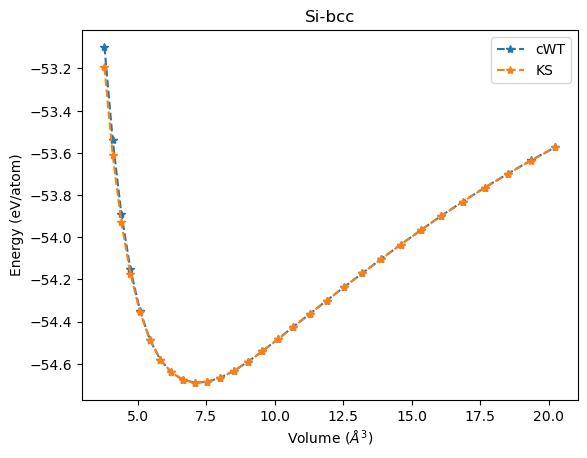

In [12]:
plt.plot(np.asarray(VOLUME)*0.529177**3/4,np.asarray(ENERGY)*27.211407/4,'*--')
plt.plot(np.asarray(VOLUME)*0.529177**3/4, np.asarray(KS_TE)*27.211407/8,'*--')
plt.xlabel('Volume ($\AA^{3}$)')
plt.ylabel('Energy (eV/atom)')
plt.title('Si-bcc')
plt.legend(['cWT','KS'])